In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn import svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import warnings

%matplotlib inline

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
df = pd.read_csv('../preprocessed_data_classification_A.csv', index_col=0)

FileNotFoundError: File b'../preprocessed_data_classification_A.csv' does not exist

In [3]:
df.shape

(7680, 323)

Befor re-sampling:
0    5079
1    2601
Name: score, dtype: int64


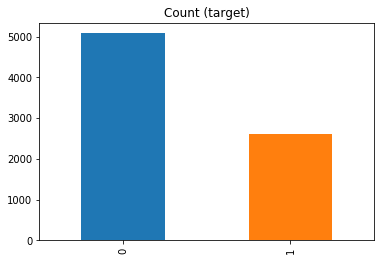

In [4]:
# Class count
count_class_0, count_class_1 = df.score.value_counts()

# Divide by class
df_class_0 = df[df['score'] == 0]
df_class_1 = df[df['score'] == 1]

print('Befor re-sampling:')
print(df.score.value_counts())

df.score.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
1    5079
0    5079
Name: score, dtype: int64


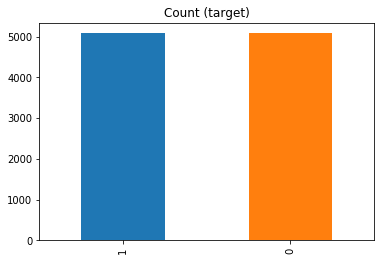

In [5]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)

df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.score.value_counts())

df_over.score.value_counts().plot(kind='bar', title='Count (target)');

In [6]:
warnings.filterwarnings('ignore')

### tree, logreg, knn

In [7]:
def scores(models):
    X = df_over.drop(columns=['score'])
    y = df_over['score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = StandardScaler()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [8]:
random_forest = RandomForestClassifier()
extra_tree = ExtraTreeClassifier()
decision_tree = DecisionTreeClassifier()
bagged_tree = BaggingClassifier()
logreg = LogisticRegression()
knn = KNeighborsClassifier()

In [9]:
a = scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

### tree, logreg, knn (with feature engineering)

In [10]:
def pca_scores(models):
    X = df_over.drop(columns=['score'])
    y = df_over['score']
    
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    
    poly_col_names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_poly, columns=poly_col_names)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = PCA()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [11]:
b = pca_scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [12]:
pd.merge(a, b, on='model')

,model,cross-val_x,train_x,test_x,cross-val_y,train_y,test_y
0,"RandomForestClassifier(bootstrap=True, class_w...",0.746390,0.963639,0.792520,0.780650,0.961801,0.834252
1,"ExtraTreeClassifier(class_weight=None, criteri...",0.714621,0.969808,0.770866,0.723810,0.969808,0.789370
2,"DecisionTreeClassifier(class_weight=None, crit...",0.721186,0.969808,0.775197,0.738248,0.969808,0.780709
3,"BaggingClassifier(base_estimator=None, bootstr...",0.742711,0.960226,0.775984,0.790759,0.962457,0.848819
4,"LogisticRegression(C=1.0, class_weight=None, d...",0.628774,0.674455,0.630315,0.706878,0.870832,0.730315
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.611445,0.766868,0.635433,0.632972,0.772381,0.644094


### XGBoost

In [13]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [14]:
model = XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.39%


In [15]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(50):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

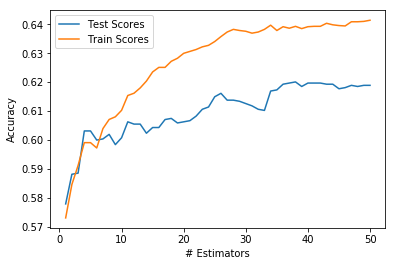

In [16]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [17]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

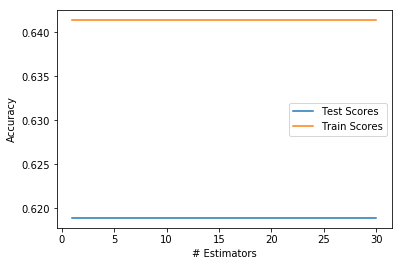

In [18]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [19]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

svc = svm.SVC(C=100)
svc.fit(X_train_sc, y_train)

y_pred = svc.predict(X_test_sc)

accuracy_score(y_test, y_pred)

0.7665354330708661

In [20]:
svc_param = {
    'C': [100, 10, 1, 0.1, 0.01],
    'kernel':['poly'],
    'degree': [2, 3, 4]
    
}

grid = GridSearchCV(
    svc,
    svc_param,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [21]:
X = df_over.drop(columns=['score'])
y = to_categorical(df_over['score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [26]:
model = Sequential()

# First hidden layer
model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(25, activation='relu'))

# For multiclass classification,
# 1 neuron
# softmax activation function
model.add(Dense(2, activation='sigmoid'))

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
results = model.fit(X_train_sc, y_train,
          epochs=30,
          validation_data=(X_test_sc, y_test))

Train on 7618 samples, validate on 2540 samples
Epoch 1/30
7618/7618 [==============================] - 1s 119us/step - loss: 0.6793 - acc: 0.5803 - val_loss: 0.6495 - val_acc: 0.6293
Epoch 2/30
7618/7618 [==============================] - 1s 69us/step - loss: 0.6039 - acc: 0.6804 - val_loss: 0.6298 - val_acc: 0.6573
Epoch 3/30
7618/7618 [==============================] - 1s 71us/step - loss: 0.5617 - acc: 0.7107 - val_loss: 0.6244 - val_acc: 0.6648
Epoch 4/30
7618/7618 [==============================] - 1s 71us/step - loss: 0.5275 - acc: 0.7392 - val_loss: 0.6161 - val_acc: 0.6734
Epoch 5/30
7618/7618 [==============================] - 1s 71us/step - loss: 0.4968 - acc: 0.7581 - val_loss: 0.6035 - val_acc: 0.6827
Epoch 6/30
7618/7618 [==============================] - 1s 72us/step - loss: 0.4697 - acc: 0.7749 - val_loss: 0.6027 - val_acc: 0.6888
Epoch 7/30
7618/7618 [==============================] - 1s 71us/step - loss: 0.4396 - acc: 0.7906 - val_loss: 0.5989 - val_acc: 0.7002
Epoch 

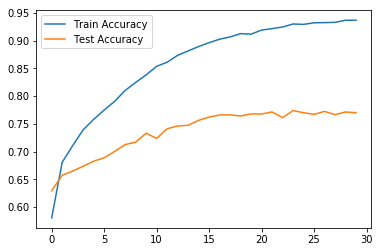

In [29]:
plt.plot(results.history['acc'], label='Train Accuracy')
plt.plot(results.history['val_acc'], label='Test Accuracy')
plt.legend()